In [21]:
# Imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords

In [22]:
# ===============================
# 1. Carregar o arquivo
# ===============================
file_path = '../data/tickets_movidesk_urgencia.xlsx'

try:
    df = pd.read_excel(file_path)
    print("Arquivo lido com sucesso!")
except FileNotFoundError:
    print(f"ERRO: Arquivo não encontrado no caminho especificado: {file_path}")
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo: {e}")

Arquivo lido com sucesso!


In [23]:
# ===============================
# 2. Limpeza inicial
# ===============================
df.dropna(subset=['Urgência', 'Texto Inicial'], inplace=True)
df = df[df['Urgência'].isin(['Urgente', 'Alta', 'Média', 'Baixa'])]

In [24]:
# ===============================
# 3. Função de limpeza de texto
# ===============================
def limpar_texto(texto):
    texto = str(texto).lower()
    texto = re.sub(r'\b(bom dia|boa tarde|olá|tudo bem|att|obrigado).*?\b', '', texto)
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [25]:
# ===============================
# 4. Aplicar a limpeza
# ===============================
df['Texto Inicial Limpo'] = df['Texto Inicial'].apply(limpar_texto)
df['Assunto Limpo'] = df['Assunto'].apply(limpar_texto)

In [26]:

# ===============================
# 5. Criar coluna combinada
# ===============================
df['TextoCombinado'] = (
    df['Texto Inicial Limpo'].fillna('') + ' ' +
    df['Assunto Limpo'].fillna('') + ' ' +
    df['Categoria'].fillna('') + ' ' +
    df['Serviço'].fillna('')
)

In [27]:
# ===============================
# 6. Codificar rótulos de urgência
# ===============================
label_map = {'Baixa': 0, 'Média': 1, 'Alta': 2, 'Urgente': 3}
df['Urgência_Label'] = df['Urgência'].map(label_map)

/var/folders/w0/q0_v_jmj1wb_4dygr_mj6gd00000gn/T/ipykernel_61655/3054128898.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Urgência', order=urgencia_counts.index, palette='crest')


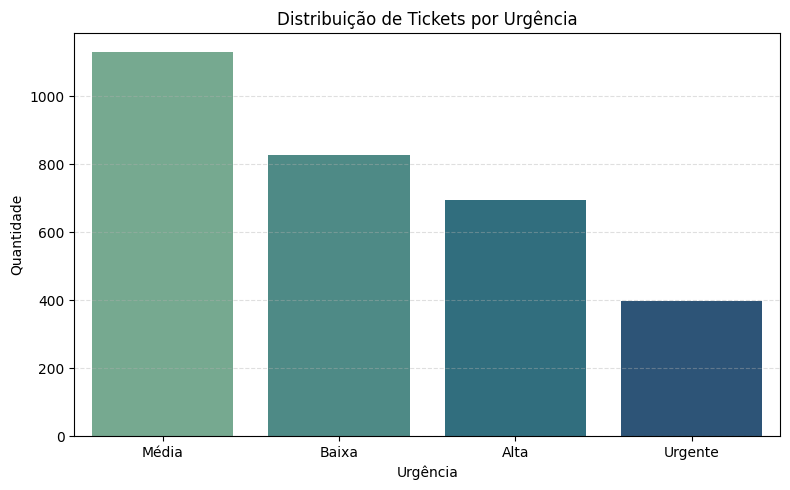

In [28]:
# ===============================
# 7. Visualização da distribuição
# ===============================
urgencia_counts = df['Urgência'].value_counts()

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Urgência', order=urgencia_counts.index, palette='crest')
plt.title('Distribuição de Tickets por Urgência')
plt.xlabel('Urgência')
plt.ylabel('Quantidade')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [29]:
# ===============================
# 8. Vetorização do texto
# ===============================

nltk.download('stopwords')

# Criar a lista de stopwords personalizadas
stopwords_pt = stopwords.words('portuguese')
stopwords_pt.extend(['urgente', 'problema', 'atendimento'])  # pode ajustar depois se quiser

# Vetorizador TF-IDF com as stopwords em português
vectorizer = TfidfVectorizer(max_features=3000, stop_words=stopwords_pt)

# Aplicar a transformação no texto combinado
X = vectorizer.fit_transform(df['TextoCombinado'])

# Variável alvo
y = df['Urgência_Label']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camillarodrigues/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
# ===============================
# 9. Divisão treino/teste
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# ===============================
# 10. Treinamento do modelo
# ===============================
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

In [31]:
# ===============================
# 11. Avaliação do modelo
# ===============================
y_pred = modelo.predict(X_test)

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

NameError: name 'modelo' is not defined

In [ ]:
# ===============================
# 12. Visualização da matriz
# ===============================
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Matriz de Confusão - Classificação de Urgência')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()